In [2]:
%pylab

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [317]:
from sklearn.externals import joblib
import seaborn as sns
sns.set_context("paper", rc={"font.size":150, "axes.titlesize":15, "axes.labelsize":15})   
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter
import scipy

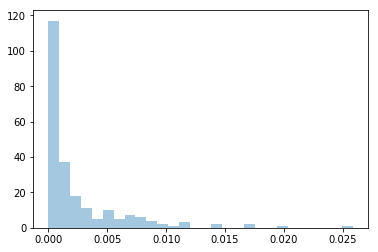

In [58]:
FI = joblib.load('multitask-patients/feature_importance22977.pkl')
sns.distplot(FI, kde=False)
plt.show()

In [52]:
(FI <= FI.max() * 0.01).sum(), FI.max(), FI.shape

(80, 0.025855718, (232,))

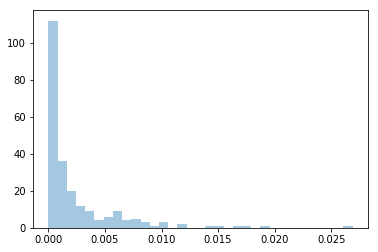

In [57]:
FI2 = joblib.load('multitask-patients/feature_importance100.pkl')
sns.distplot(FI2, kde=False)
plt.show()

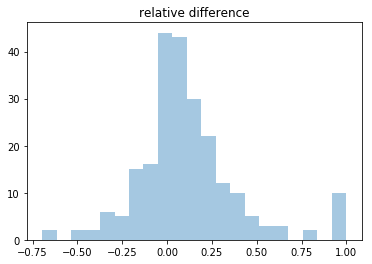

In [55]:
m = np.max(np.vstack([FI, FI2]), 0)
m[m == 0] = 1 # aviod division by 0
sns.distplot((FI - FI2) / m, kde=False)
plt.title('relative difference')
plt.show()

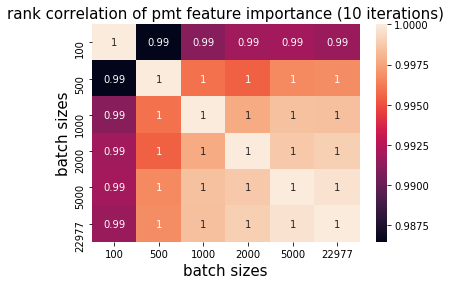

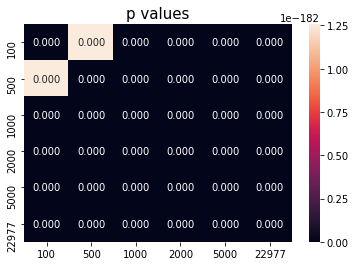

In [340]:
fns = [
    '100',
    '500',
    '1000',
    '2000',
    '5000',
    '22977',
]
pmts = []
for fn in fns:
    pmts.append(joblib.load('multitask-patients/feature_importance{}.pkl'.format(fn)))
    
rho, p = scipy.stats.spearmanr(np.array(pmts).T)
rho_df = pd.DataFrame(rho, index=fns, columns=fns)
sns.heatmap(rho_df, annot=True)
plt.title('rank correlation of pmt feature importance (10 iterations)', fontsize=15)
plt.ylabel('batch sizes', fontsize=15)
plt.xlabel('batch sizes', fontsize=15)
plt.show()

sns.heatmap(pd.DataFrame(p, index=fns, columns=fns), annot=True, fmt='.3f')
plt.title('p values', fontsize=15)
plt.show()

,100,500,1000,2000,5000,22977
100,1.000000,0.986472,0.991092,0.991889,0.991920,0.991679
500,0.986472,1.000000,0.995935,0.995503,0.996707,0.996794
1000,0.991092,0.995935,1.000000,0.997742,0.998508,0.998462
2000,0.991889,0.995503,0.997742,1.000000,0.998755,0.998950
5000,0.991920,0.996707,0.998508,0.998755,1.000000,0.999637
22977,0.991679,0.996794,0.998462,0.998950,0.999637,1.000000


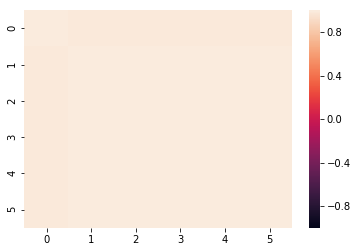

In [325]:
sns.heatmap(rho, vmin=-1, vmax=1)

# preliminary result

In [79]:
fns = [
    'global',
    'global_pytorch',
    'global_pytorch_pmt',    
    'mtl_pytorch',
    'moe',
    'separate_mtl',
    'snapshot_mtl',
]
pd_dict = {
    'N': [4905, 6981, 11487, 5208, 4244, 32825, 32825],
    'n': [357, 140, 1178, 423, 294, 2392, 2392]   
}
for fn in fns:    
    pd_dict[fn] = np.load('multitask-patients/mortality_test/results/test_auc_on_{}_single.npy'.format(fn))
df = pd.DataFrame.from_dict(pd_dict)
df = df.rename({0: 'CCU', 1: 'CSRU', 2: 'MICU', 3: 'SICU', 4: 'TSICU', 5: 'Macro', 6: 'Micro'}, axis='index')
df.round(3)[['N', 'n'] + fns]

,N,n,global,global_pytorch,global_pytorch_pmt,mtl_pytorch,moe,separate_mtl,snapshot_mtl
CCU,4905,357,0.855,0.857,0.862,0.843,0.865,0.810,0.854
CSRU,6981,140,0.929,0.909,0.917,0.869,0.924,0.862,0.935
MICU,11487,1178,0.826,0.825,0.828,0.821,0.829,0.820,0.842
SICU,5208,423,0.840,0.863,0.856,0.847,0.861,0.834,0.866
TSICU,4244,294,0.884,0.888,0.887,0.872,0.866,0.840,0.889
Macro,32825,2392,0.867,0.868,0.870,0.850,0.869,0.833,0.877
Micro,32825,2392,0.866,0.866,0.869,0.855,0.869,0.841,0.877


# Clustering approaches

In [316]:
fns = [
    'INPUT_pmt',
    'AE',
    'GLOBAL',
    'VAL_CURVE'
]

for fn in fns:
    a = np.load('multitask-patients/cluster_membership/{}_test_clusters.npy'.format(fn))
    print(fn, Counter(a))

('INPUT_pmt', Counter({1: 20362, 0: 8844, 2: 3619}))
('AE', Counter({2: 16428, 0: 10641, 1: 5756}))
('GLOBAL', Counter({2: 16472, 0: 8861, 1: 7492}))
('VAL_CURVE', Counter({1: 17977, 2: 14025, 0: 823}))


Counter({1: 1696, 2: 1492, 0: 95})


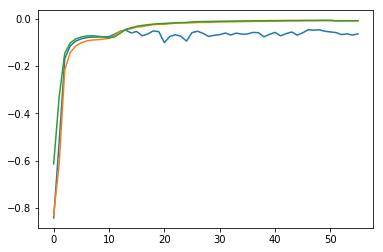

In [108]:
curves = joblib.load('multitask-patients/val_curves.pkl')
ass = joblib.load('multitask-patients/val_assignments.pkl')
print(Counter(ass))
for i in np.random.choice(len(curves), 3):
    plt.plot(curves[i])
plt.show()

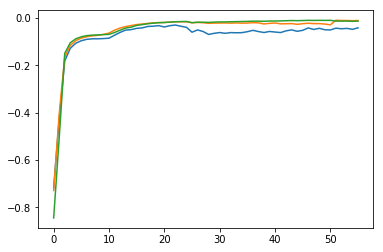

In [114]:
c = curves[ass==2]
for i in np.random.choice(len(c), 3):
    plt.plot(c[i])
plt.show()

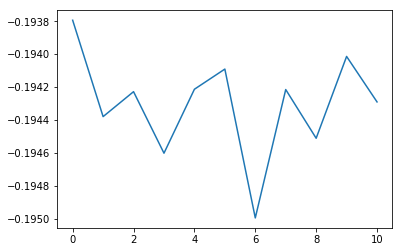

(array([-0.193794  , -0.19437951, -0.194228  , -0.19460168, -0.19421324,
       -0.19409066, -0.194995  , -0.19421507, -0.19451095, -0.19401392,
       -0.19429024], dtype=float32), (3283, 56))


In [130]:
plt.plot(curves.mean(0)[51-11:51])
plt.show()
print(curves.mean(0)[51-11:51], curves.shape)

In [128]:
train_log = joblib.load('multitask-patients/mortality_test/checkpoints/global_pytorch_lstm_shared_1_layers_16_units_0_dense_shared_0_dense_units_mortality/log')
print(len([l['epoch'] for l in train_log]))

51


In [133]:
train_log = joblib.load('multitask-patients/clustering_models/gate_VAL_CURVE_3_24_pt_log')
train_log[0].keys()

['loss', 'epoch', 'val_loss']

# Randomness make a difference

In [278]:
run = 4
fns = [
    'global',
    'global_pytorch',
    'multitask',
    'mtl_pytorch',
    'moe'
]
pd_dict = {}
for fn in fns:
    pd_dict[fn] = np.load('clean_template/mortality_test/results/test_auc_on_{}_single{}.npy'.format(fn, run))
pd.DataFrame.from_dict(pd_dict)

df = pd.DataFrame.from_dict(pd_dict)
df = df.rename({0: 'CCU', 1: 'CSRU', 2: 'MICU', 3: 'SICU', 4: 'TSICU', 5: 'Macro', 6: 'Micro'}, axis='index')
df.round(3)[fns]

,global,global_pytorch,multitask,mtl_pytorch,moe
CCU,0.859,0.852,0.858,0.839,0.860
CSRU,0.908,0.913,0.873,0.834,0.924
MICU,0.830,0.825,0.826,0.827,0.836
SICU,0.845,0.849,0.863,0.845,0.848
TSICU,0.898,0.876,0.902,0.884,0.896
Macro,0.868,0.863,0.864,0.846,0.873
Micro,0.869,0.865,0.867,0.857,0.871


In [312]:
fns = [
    'global',
    'global_pytorch',
    'multitask',
    'mtl_pytorch',
    'moe'
]
pds = {}
for fn in fns:
    pd_dict = {}
    for run in range(1, 31):
        pd_dict['run' + str(run)] =np.load('clean_template/mortality_test/results/test_auc_on_{}_single{}.npy'.format(fn, run))    
    df = pd.DataFrame.from_dict(pd_dict)
    df = df.rename({0: 'CCU', 1: 'CSRU', 2: 'MICU', 3: 'SICU', 4: 'TSICU', 5: 'Macro', 6: 'Micro'}, axis='index')    
    pds[fn] = df.transpose()

for fn in fns:
    print('\n' + fn)
    print(pds[fn].describe().round(3))


global
          CCU    CSRU    MICU    SICU   TSICU   Macro   Micro
count  30.000  30.000  30.000  30.000  30.000  30.000  30.000
mean    0.859   0.912   0.829   0.850   0.890   0.868   0.869
std     0.010   0.016   0.007   0.010   0.007   0.005   0.004
min     0.838   0.869   0.816   0.818   0.872   0.858   0.860
25%     0.853   0.905   0.824   0.848   0.886   0.864   0.866
50%     0.859   0.913   0.828   0.852   0.891   0.869   0.870
75%     0.866   0.922   0.833   0.855   0.895   0.871   0.871
max     0.875   0.938   0.843   0.866   0.903   0.878   0.876

global_pytorch
          CCU    CSRU    MICU    SICU   TSICU   Macro   Micro
count  30.000  30.000  30.000  30.000  30.000  30.000  30.000
mean    0.852   0.914   0.829   0.850   0.887   0.867   0.867
std     0.007   0.011   0.007   0.010   0.008   0.003   0.004
min     0.832   0.893   0.811   0.825   0.869   0.858   0.857
25%     0.849   0.909   0.825   0.844   0.883   0.864   0.864
50%     0.852   0.912   0.830   0.851   0.887 

In [353]:
fns = [
    'global',
    'global_pytorch',
    'multitask',
    'mtl_pytorch',
    'moe'
]

pd_dict = {}
val_best = {}
for fn in fns:
    for run in range(1, 31):
        if fn in ['global', 'multitask', 'separate']: # original code
            val_micro_auc = np.load('clean_template/mortality_test/results/{}_model_results_no_sample_weights{}.npy'.format(fn, run))[0][-1][-1]
        else:
            val_micro_auc = np.load('clean_template/mortality_test/results/val_auc_on_{}_single{}.npy'.format(fn, run))[-1]
        if not val_best.get(fn) or val_best[fn] < val_micro_auc:
            val_best[fn] = val_micro_auc
            pd_dict[fn] = np.load('clean_template/mortality_test/results/test_auc_on_{}_single{}.npy'.format(fn, run))    
df = pd.DataFrame.from_dict(pd_dict)
df = df.rename({0: 'CCU', 1: 'CSRU', 2: 'MICU', 3: 'SICU', 4: 'TSICU', 5: 'Macro', 6: 'Micro'}, axis='index')    
df.round(3)[fns]

,global,global_pytorch,multitask,mtl_pytorch,moe
CCU,0.875,0.847,0.858,0.851,0.847
CSRU,0.902,0.924,0.897,0.883,0.909
MICU,0.823,0.838,0.823,0.811,0.835
SICU,0.850,0.863,0.853,0.845,0.871
TSICU,0.893,0.875,0.890,0.880,0.901
Macro,0.869,0.869,0.864,0.854,0.873
Micro,0.868,0.871,0.866,0.853,0.872


### Some hyperparameter search: lr=0.001 instead of lr=0.0001 in the above

In [351]:
run = 1
suffix = '_lr'
fns = [
    'global',
    'global_pytorch',
    'multitask',
    'mtl_pytorch',
    'moe'
]
pd_dict = {}
for fn in fns:
    pd_dict[fn] = np.load('clean_template/mortality_test/results/test_auc_on_{}_single{}{}.npy'.format(fn, run, suffix))
pd.DataFrame.from_dict(pd_dict)

df = pd.DataFrame.from_dict(pd_dict)
df = df.rename({0: 'CCU', 1: 'CSRU', 2: 'MICU', 3: 'SICU', 4: 'TSICU', 5: 'Macro', 6: 'Micro'}, axis='index')
df.round(3)[fns]

,global,global_pytorch,multitask,mtl_pytorch,moe
CCU,0.865,0.862,0.852,0.858,0.860
CSRU,0.858,0.926,0.854,0.898,0.918
MICU,0.812,0.834,0.816,0.832,0.843
SICU,0.872,0.873,0.841,0.854,0.862
TSICU,0.884,0.898,0.867,0.900,0.894
Macro,0.858,0.879,0.846,0.868,0.875
Micro,0.861,0.875,0.852,0.869,0.876


In [363]:
suffix = '_lr'
fns = [
    'global',
    'global_pytorch',
    'multitask',
    'mtl_pytorch',
    'moe'
]
pds = {}
for fn in fns:
    pd_dict = {}
    for run in range(1, 31):
        pd_dict['run' + str(run)] =np.load('clean_template/mortality_test/results/test_auc_on_{}_single{}{}.npy'.format(fn, run, suffix))    
    df = pd.DataFrame.from_dict(pd_dict)
    df = df.rename({0: 'CCU', 1: 'CSRU', 2: 'MICU', 3: 'SICU', 4: 'TSICU', 5: 'Macro', 6: 'Micro'}, axis='index')    
    pds[fn] = df.transpose()

for fn in fns:
    print('\n' + fn)
    print(pds[fn].describe().round(3))


global
          CCU    CSRU    MICU    SICU   TSICU   Macro   Micro
count  30.000  30.000  30.000  30.000  30.000  30.000  30.000
mean    0.853   0.898   0.818   0.851   0.893   0.862   0.860
std     0.016   0.021   0.012   0.012   0.011   0.009   0.009
min     0.809   0.858   0.797   0.821   0.860   0.836   0.840
25%     0.845   0.883   0.809   0.842   0.889   0.859   0.855
50%     0.852   0.899   0.817   0.851   0.896   0.862   0.860
75%     0.865   0.913   0.827   0.860   0.900   0.868   0.866
max     0.877   0.936   0.842   0.872   0.911   0.880   0.878

global_pytorch
          CCU    CSRU    MICU    SICU   TSICU   Macro   Micro
count  30.000  30.000  30.000  30.000  30.000  30.000  30.000
mean    0.856   0.921   0.836   0.863   0.888   0.873   0.873
std     0.007   0.008   0.006   0.007   0.007   0.003   0.003
min     0.845   0.906   0.823   0.852   0.871   0.868   0.868
25%     0.852   0.915   0.833   0.857   0.884   0.870   0.870
50%     0.854   0.922   0.835   0.862   0.888 

In [369]:
suffix = '_lr'
fns = [
    'global',
    'global_pytorch',
    'multitask',
    'mtl_pytorch',
    'moe'
]

pd_dict = {}
val_best = {}
for fn in fns:
    for run in range(1, 31):
        if fn in ['global', 'multitask', 'separate']: # original code
            val_micro_auc = np.load('clean_template/mortality_test/results/{}_model_results_no_sample_weights{}{}.npy'.format(fn, run, suffix))[0][-1][-1]
        else:
            val_micro_auc = np.load('clean_template/mortality_test/results/val_auc_on_{}_single{}{}.npy'.format(fn, run, suffix))[-1]
        if not val_best.get(fn) or val_best[fn] < val_micro_auc:
            val_best[fn] = val_micro_auc
            pd_dict[fn] = np.load('clean_template/mortality_test/results/test_auc_on_{}_single{}{}.npy'.format(fn, run, suffix))    
df = pd.DataFrame.from_dict(pd_dict)
df = df.rename({0: 'CCU', 1: 'CSRU', 2: 'MICU', 3: 'SICU', 4: 'TSICU', 5: 'Macro', 6: 'Micro'}, axis='index')    
df.round(3)[fns]

,global,global_pytorch,multitask,mtl_pytorch,moe
CCU,0.877,0.862,0.870,0.875,0.850
CSRU,0.936,0.926,0.863,0.911,0.927
MICU,0.841,0.834,0.821,0.834,0.835
SICU,0.848,0.873,0.876,0.872,0.861
TSICU,0.897,0.898,0.894,0.899,0.893
Macro,0.880,0.879,0.865,0.878,0.873
Micro,0.877,0.875,0.864,0.875,0.872


# Results with hyperparameter search

In [549]:
exp_names = ['global_plus_mtl_exp', 'ae_plus_mtl_exp', 
             'val_curve_plus_mtl_exp', 'global_plus_snapshot_exp', 
             'val_curve_plus_snapshot_exp'
            ]
runnames = list(range(30))

pds = {}
for exp_name in exp_names:
    pd_dict = {}
    for run in runnames: 
        try: # todo: figure out what's wrong with somd of the runs
            pd_dict[str(run)] =np.load('multitask-patients/mortality_test/results/test_auc_on_{}_single_{}.npy'.format(run, exp_name))[-2:]
        except:
            print("{} missing run {}".format(exp_name, run))
            continue

    df = pd.DataFrame.from_dict(pd_dict)
    df = df.rename({0: 'Macro', 1: 'Micro'}, axis='index')    
    # df = df.rename({0: 'CCU', 1: 'CSRU', 2: 'MICU', 3: 'SICU', 4: 'TSICU', 5: 'Macro', 6: 'Micro'}, axis='index')    
    pds[exp_name] = df.transpose()

for exp_name in exp_names:
    print('\n' + exp_name)
    print(pds[exp_name].describe().round(3))

global_plus_mtl_exp missing run 22
global_plus_mtl_exp missing run 24
ae_plus_mtl_exp missing run 9
val_curve_plus_mtl_exp missing run 9
val_curve_plus_mtl_exp missing run 16
val_curve_plus_mtl_exp missing run 19
val_curve_plus_mtl_exp missing run 20
val_curve_plus_mtl_exp missing run 25
val_curve_plus_mtl_exp missing run 27
global_plus_snapshot_exp missing run 0
global_plus_snapshot_exp missing run 13
global_plus_snapshot_exp missing run 22
global_plus_snapshot_exp missing run 23
global_plus_snapshot_exp missing run 24
val_curve_plus_snapshot_exp missing run 9
val_curve_plus_snapshot_exp missing run 16
val_curve_plus_snapshot_exp missing run 19
val_curve_plus_snapshot_exp missing run 20
val_curve_plus_snapshot_exp missing run 25
val_curve_plus_snapshot_exp missing run 27

global_plus_mtl_exp
        Macro   Micro
count  28.000  28.000
mean    0.688   0.862
std     0.116   0.013
min     0.502   0.824
25%     0.570   0.861
50%     0.723   0.865
75%     0.793   0.869
max     0.818   0.88

In [596]:
exp_names = ['global_plus_mtl_exp', 'ae_plus_mtl_exp', 
             'val_curve_plus_mtl_exp', 'global_plus_snapshot_exp', 
             'val_curve_plus_snapshot_exp'
            ]
runnames = list(range(30))

choose_val_criterion = 'Micro' # can only be Macro or Micro; here only make sense for Micro b/c they have different clusters
choose_val_idx = -1 if choose_val_criterion == 'Micro' else -2
print('Choosing hyperparameter using {} auc'.format(choose_val_criterion))

pd_dict = {}
val_best = {}
val_best_name = {}
for exp_name in exp_names:
    for run in runnames:
        try: # todo: figure out what's wrong with some of the runs
            val_micro_auc = np.load('multitask-patients/mortality_test/results/val_auc_on_{}_single_{}.npy'.format(run, exp_name))[choose_val_idx]
            np.load('multitask-patients/mortality_test/results/test_auc_on_{}_single_{}.npy'.format(run, exp_name))
        except:
            print("{} missing run {}".format(exp_name, run))
            continue
            
        if not val_best.get(exp_name) or val_best[exp_name] < val_micro_auc:
            val_best[exp_name] = val_micro_auc
            val_best_name[exp_name] = 'multitask-patients/mortality_test/results/test_auc_on_{}_single_{}.npy'.format(run, exp_name)
            
            pd_dict[exp_name] = np.load(val_best_name[exp_name])[-2:]
    
df = pd.DataFrame.from_dict(pd_dict)
df = df.rename({0: 'Macro', 1: 'Micro'}, axis='index')    
# df = df.rename({0: 'CCU', 1: 'CSRU', 2: 'MICU', 3: 'SICU', 4: 'TSICU', 5: 'Macro', 6: 'Micro'}, axis='index')    
df.round(3)[exp_names]

Choosing hyperparameter using Micro auc
global_plus_mtl_exp missing run 22
global_plus_mtl_exp missing run 24
ae_plus_mtl_exp missing run 9
val_curve_plus_mtl_exp missing run 9
val_curve_plus_mtl_exp missing run 16
val_curve_plus_mtl_exp missing run 19
val_curve_plus_mtl_exp missing run 20
val_curve_plus_mtl_exp missing run 25
val_curve_plus_mtl_exp missing run 27
global_plus_snapshot_exp missing run 0
global_plus_snapshot_exp missing run 13
global_plus_snapshot_exp missing run 22
global_plus_snapshot_exp missing run 23
global_plus_snapshot_exp missing run 24
val_curve_plus_snapshot_exp missing run 9
val_curve_plus_snapshot_exp missing run 16
val_curve_plus_snapshot_exp missing run 19
val_curve_plus_snapshot_exp missing run 20
val_curve_plus_snapshot_exp missing run 25
val_curve_plus_snapshot_exp missing run 27


,global_plus_mtl_exp,ae_plus_mtl_exp,val_curve_plus_mtl_exp,global_plus_snapshot_exp,val_curve_plus_snapshot_exp
Macro,0.814,0.879,0.881,0.745,0.878
Micro,0.880,0.876,0.881,0.876,0.878


# after debugging all settings

In [659]:
exp_names = ['global_plus_mtl_exp', 'ae_plus_mtl_exp', 
             'val_curve_plus_mtl_exp', 'global_plus_snapshot_exp', 
             'val_curve_plus_snapshot_exp'
            ]
runnames = list(range(30))

pds = {}
for exp_name in exp_names:
    pd_dict = {}
    for run in runnames: 
        try: # todo: figure out what's wrong with somd of the runs
            pd_dict[str(run)] =np.load('multitask-patients/mortality_test/results/test_auc_on_{}_single_{}.npy'.format(run, exp_name))[-2:]
        except:
            print("{} missing run {}".format(exp_name, run))
            continue

    df = pd.DataFrame.from_dict(pd_dict)
    df = df.rename({0: 'Macro', 1: 'Micro'}, axis='index')    
    # df = df.rename({0: 'CCU', 1: 'CSRU', 2: 'MICU', 3: 'SICU', 4: 'TSICU', 5: 'Macro', 6: 'Micro'}, axis='index')    
    pds[exp_name] = df.transpose()

for exp_name in exp_names:
    print('\n' + exp_name)
    print(pds[exp_name].describe().round(3))


global_plus_mtl_exp
        Macro   Micro
count  30.000  30.000
mean    0.700   0.855
std     0.109   0.026
min     0.501   0.745
25%     0.600   0.850
50%     0.741   0.865
75%     0.792   0.868
max     0.818   0.880

ae_plus_mtl_exp
        Macro   Micro
count  30.000  30.000
mean    0.862   0.867
std     0.021   0.007
min     0.798   0.851
25%     0.859   0.864
50%     0.866   0.867
75%     0.876   0.874
max     0.889   0.878

val_curve_plus_mtl_exp
        Macro   Micro
count  30.000  30.000
mean    0.767   0.848
std     0.061   0.039
min     0.567   0.669
25%     0.732   0.841
50%     0.771   0.862
75%     0.797   0.867
max     0.875   0.879

global_plus_snapshot_exp
        Macro   Micro
count  30.000  30.000
mean    0.716   0.853
std     0.079   0.024
min     0.557   0.780
25%     0.648   0.850
50%     0.744   0.862
75%     0.780   0.867
max     0.811   0.878

val_curve_plus_snapshot_exp
        Macro   Micro
count  30.000  30.000
mean    0.762   0.846
std     0.056   0.042
min

In [658]:
exp_names = ['global_plus_mtl_exp', 
             'ae_plus_mtl_exp', 
             'val_curve_plus_mtl_exp', 'global_plus_snapshot_exp', 
             'val_curve_plus_snapshot_exp'
            ]
runnames = list(range(30))

choose_val_criterion = 'Micro' # can only be Macro or Micro; here only make sense for Micro b/c they have different clusters
choose_val_idx = -1 if choose_val_criterion == 'Micro' else -2
print('Choosing hyperparameter using {} auc'.format(choose_val_criterion))

pd_dict = {}
val_best = {}
val_best_name = {}
for exp_name in exp_names:
    for run in runnames:
        try: # todo: figure out what's wrong with some of the runs
            val_micro_auc = np.load('multitask-patients/mortality_test/results/val_auc_on_{}_single_{}.npy'.format(run, exp_name))[choose_val_idx]
            np.load('multitask-patients/mortality_test/results/test_auc_on_{}_single_{}.npy'.format(run, exp_name))
        except:
            print("{} missing run {}".format(exp_name, run))
            continue
            
        if not val_best.get(exp_name) or val_best[exp_name] < val_micro_auc:
            val_best[exp_name] = val_micro_auc
            val_best_name[exp_name] = 'multitask-patients/mortality_test/results/test_auc_on_{}_single_{}.npy'.format(run, exp_name)
            
            pd_dict[exp_name] = np.load(val_best_name[exp_name])[-2:]
    
df = pd.DataFrame.from_dict(pd_dict)
df = df.rename({0: 'Macro', 1: 'Micro'}, axis='index')    
# df = df.rename({0: 'CCU', 1: 'CSRU', 2: 'MICU', 3: 'SICU', 4: 'TSICU', 5: 'Macro', 6: 'Micro'}, axis='index')    
df.round(3)[exp_names]

Choosing hyperparameter using Micro auc


,global_plus_mtl_exp,ae_plus_mtl_exp,val_curve_plus_mtl_exp,global_plus_snapshot_exp,val_curve_plus_snapshot_exp
Macro,0.814,0.879,0.875,0.777,0.782
Micro,0.880,0.876,0.875,0.878,0.876


In [644]:
exp_names = ['MTL_saps_exp', 'snapshot_saps_exp']
runnames = list(range(30))

pds = {}
for exp_name in exp_names:
    pd_dict = {}
    for run in runnames:
        pd_dict[str(run)] =np.load('multitask-patients/mortality_test/results/test_auc_on_{}_single_{}.npy'.format(run, exp_name))    
    df = pd.DataFrame.from_dict(pd_dict)
    df = df.rename({0: 'q1', 1: 'q2', 2: 'q3', 3: 'q4', 4: 'Macro', 5: 'Micro'}, axis='index')    
    pds[exp_name] = df.transpose()

for exp_name in exp_names:
    print('\n' + exp_name)
    print(pds[exp_name].describe().round(3))
    
choose_val_criterion = 'Micro' # can only be Macro or Micro
choose_val_idx = -1 if choose_val_criterion == 'Micro' else -2
print('Choosing hyperparameter using {} auc'.format(choose_val_criterion))
pd_dict = {}
val_best = {}
val_best_name = {}
for exp_name in exp_names:
    for run in runnames:
        val_micro_auc = np.load('multitask-patients/mortality_test/results/val_auc_on_{}_single_{}.npy'.format(run, exp_name))[choose_val_idx]
        if not val_best.get(exp_name) or val_best[exp_name] < val_micro_auc:
            val_best[exp_name] = val_micro_auc
            val_best_name[exp_name] = 'multitask-patients/mortality_test/results/test_auc_on_{}_single_{}.npy'.format(run, exp_name)
            pd_dict[exp_name] = np.load(val_best_name[exp_name])    
df = pd.DataFrame.from_dict(pd_dict)
df = df.rename({0: 'q1', 1: 'q2', 2: 'q3', 3: 'q4', 4: 'Macro', 5: 'Micro'}, axis='index')    
df.round(3)[exp_names]


MTL_saps_exp
           q1      q2      q3      q4   Macro   Micro
count  30.000  30.000  30.000  30.000  30.000  30.000
mean    0.851   0.834   0.792   0.801   0.820   0.879
std     0.032   0.026   0.015   0.012   0.015   0.007
min     0.771   0.783   0.737   0.758   0.786   0.855
25%     0.833   0.818   0.786   0.798   0.808   0.875
50%     0.845   0.843   0.794   0.806   0.821   0.880
75%     0.871   0.852   0.803   0.809   0.831   0.883
max     0.934   0.864   0.815   0.817   0.846   0.888

snapshot_saps_exp
           q1      q2      q3      q4   Macro   Micro
count  30.000  30.000  30.000  30.000  30.000  30.000
mean    0.788   0.797   0.776   0.778   0.785   0.858
std     0.048   0.046   0.023   0.026   0.032   0.021
min     0.707   0.699   0.726   0.716   0.722   0.808
25%     0.747   0.778   0.773   0.771   0.764   0.855
50%     0.799   0.808   0.789   0.788   0.794   0.863
75%     0.829   0.831   0.793   0.796   0.815   0.874
max     0.892   0.851   0.795   0.804   0.824   0

,MTL_saps_exp,snapshot_saps_exp
q1,0.934,0.825
q2,0.840,0.851
q3,0.815,0.792
q4,0.797,0.804
Macro,0.846,0.818
Micro,0.885,0.881


In [643]:
exp_names = ['moe_exp', 'global_exp', 'MTL_careunit_exp', 'snapshot_careunit_exp']
runnames = list(range(30))

pds = {}
for exp_name in exp_names:
    pd_dict = {}
    for run in runnames:
        pd_dict[str(run)] =np.load('multitask-patients/mortality_test/results/test_auc_on_{}_single_{}.npy'.format(run, exp_name))    
    df = pd.DataFrame.from_dict(pd_dict)
    df = df.rename({0: 'CCU', 1: 'CSRU', 2: 'MICU', 3: 'SICU', 4: 'TSICU', 5: 'Macro', 6: 'Micro'}, axis='index')    
    pds[exp_name] = df.transpose()

for exp_name in exp_names:
    print('\n' + exp_name)
    print(pds[exp_name].describe().round(3))
    
choose_val_criterion = 'Micro' # can only be Macro or Micro
choose_val_idx = -1 if choose_val_criterion == 'Micro' else -2
print('Choosing hyperparameter using {} auc'.format(choose_val_criterion))

pd_dict = {}
val_best = {}
val_best_name = {}
for exp_name in exp_names:
    for run in runnames:
        val_micro_auc = np.load('multitask-patients/mortality_test/results/val_auc_on_{}_single_{}.npy'.format(run, exp_name))[choose_val_idx]
        if not val_best.get(exp_name) or val_best[exp_name] < val_micro_auc:
            val_best[exp_name] = val_micro_auc
            val_best_name[exp_name] = 'multitask-patients/mortality_test/results/test_auc_on_{}_single_{}.npy'.format(run, exp_name)
            pd_dict[exp_name] = np.load(val_best_name[exp_name])    
df = pd.DataFrame.from_dict(pd_dict)
df = df.rename({0: 'CCU', 1: 'CSRU', 2: 'MICU', 3: 'SICU', 4: 'TSICU', 5: 'Macro', 6: 'Micro'}, axis='index')    

import pprint
pprint.pprint(val_best)
pprint.pprint(val_best_name)

# if have bootstrap result, run this
# aucs = np.load('multitask-patients/mortality_test/results/test_auc_on_5_all_MTL_first_unit_exp.npy')
# print(aucs.shape)
# print(np.percentile(aucs, [25, 50, 75], axis=1))

df.round(3)[exp_names]


moe_exp
          CCU    CSRU    MICU    SICU   TSICU   Macro   Micro
count  30.000  30.000  30.000  30.000  30.000  30.000  30.000
mean    0.855   0.927   0.836   0.865   0.889   0.874   0.874
std     0.009   0.012   0.010   0.008   0.008   0.007   0.006
min     0.828   0.882   0.813   0.838   0.870   0.846   0.851
25%     0.851   0.922   0.830   0.861   0.885   0.873   0.870
50%     0.855   0.927   0.839   0.865   0.889   0.875   0.875
75%     0.861   0.933   0.845   0.869   0.894   0.878   0.878
max     0.869   0.944   0.849   0.879   0.902   0.882   0.881

global_exp
          CCU    CSRU    MICU    SICU   TSICU   Macro   Micro
count  30.000  30.000  30.000  30.000  30.000  30.000  30.000
mean    0.855   0.925   0.833   0.865   0.889   0.873   0.872
std     0.008   0.010   0.008   0.008   0.010   0.005   0.005
min     0.842   0.894   0.814   0.846   0.867   0.857   0.857
25%     0.850   0.919   0.828   0.859   0.883   0.870   0.870
50%     0.857   0.925   0.834   0.866   0.891   0

,moe_exp,global_exp,MTL_careunit_exp,snapshot_careunit_exp
CCU,0.859,0.857,0.850,0.859
CSRU,0.937,0.925,0.919,0.912
MICU,0.844,0.837,0.849,0.844
SICU,0.865,0.867,0.870,0.867
TSICU,0.888,0.895,0.894,0.890
Macro,0.878,0.876,0.876,0.875
Micro,0.878,0.875,0.878,0.875


### partial dependence plot for models only

In [511]:
# get validation performance
exp_names = ['moe_exp', 'global_exp', 'MTL_careunit_exp']
runnames = list(range(30))

pds = {}
for exp_name in exp_names:
    pd_dict = {}
    for run in runnames:
        pd_dict[str(run)] =np.load('multitask-patients/mortality_test/results/val_auc_on_{}_single_{}.npy'.format(run, exp_name))    
    df = pd.DataFrame.from_dict(pd_dict)
    df = df.rename({0: 'CCU', 1: 'CSRU', 2: 'MICU', 3: 'SICU', 4: 'TSICU', 5: 'Macro', 6: 'Micro'}, axis='index')    
    pds[exp_name] = df.transpose()

val_dfs = pds
val_dfs['moe_exp']

,CCU,CSRU,MICU,SICU,TSICU,Macro,Micro
0,0.873927,0.936486,0.824860,0.867850,0.825077,0.865640,0.863008
1,0.896654,0.946257,0.845641,0.880826,0.866521,0.887180,0.884841
10,0.888510,0.935841,0.834965,0.854555,0.795243,0.861823,0.865580
11,0.880808,0.940634,0.813591,0.873040,0.833028,0.868220,0.862721
12,0.871023,0.937408,0.834121,0.870445,0.839431,0.870486,0.869617
13,0.870455,0.951327,0.832970,0.895869,0.853152,0.880755,0.877735
14,0.896717,0.931692,0.840474,0.888294,0.829018,0.877239,0.876308
15,0.873169,0.930494,0.810051,0.855350,0.828173,0.859447,0.855008
16,0.897475,0.948101,0.847667,0.872087,0.802702,0.873606,0.876309
17,0.874874,0.924318,0.829101,0.854661,0.813538,0.859298,0.861604


In [484]:
# plot partial dependence of all the hyper-parameters, based on validation performance
from collections import defaultdict
settings = joblib.load('multitask-patients/settings/model_joint_settings.pkl')
pd_dict = defaultdict(lambda: np.zeros(len(settings)))
for i, setting in enumerate(settings):
    for arg in setting:
        if type(arg) in [list, tuple]:
            k, v = arg
        else:
            k, v = arg, 1
        if k.startswith('--'):
            k = k[2:]
        elif k.startswith('-'):
            k = k[1:]
        
        if k == 'lr':
            k = 'log_lr'
            v = np.log10(v)
        if k == 'wd':
            k = 'log_wd'
            v = np.log10(v)
        pd_dict[k][i] = v
        
settings_df = pd.DataFrame.from_dict(pd_dict)
settings_df

,dense_shared_layer_size,log_lr,log_wd,lstm_layer_size,multi_layer_size,num_dense_shared_layers,num_multi_layers,runname
0,300.0,-3.509574,-5.045501,16.0,100.0,0.0,2.0,0.0
1,16.0,-3.156900,-3.808226,300.0,300.0,0.0,2.0,1.0
2,300.0,-3.160954,-9.793811,100.0,16.0,1.0,0.0,2.0
3,100.0,-2.906628,-3.395235,16.0,16.0,0.0,3.0,3.0
4,100.0,-2.251728,-4.612949,16.0,300.0,2.0,1.0,4.0
5,300.0,-3.751864,-8.642422,300.0,300.0,1.0,1.0,5.0
6,100.0,-3.571659,-5.478277,100.0,16.0,3.0,1.0,6.0
7,16.0,-3.417487,-6.914898,300.0,300.0,1.0,3.0,7.0
8,300.0,-3.192941,-9.316436,300.0,100.0,3.0,2.0,8.0
9,100.0,-3.121942,-8.211030,16.0,16.0,3.0,1.0,9.0


moe_exp


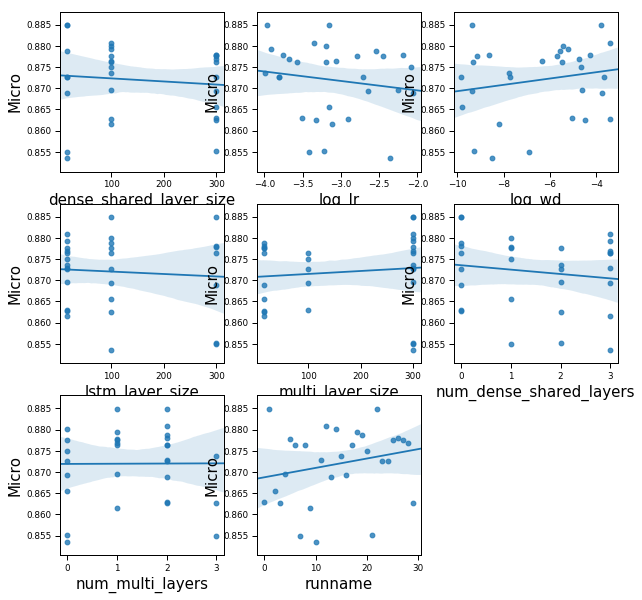

global_exp


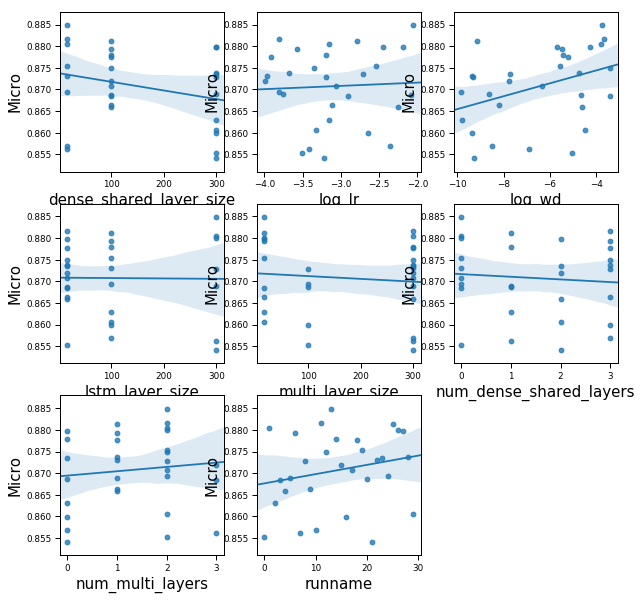

MTL_first_unit_exp


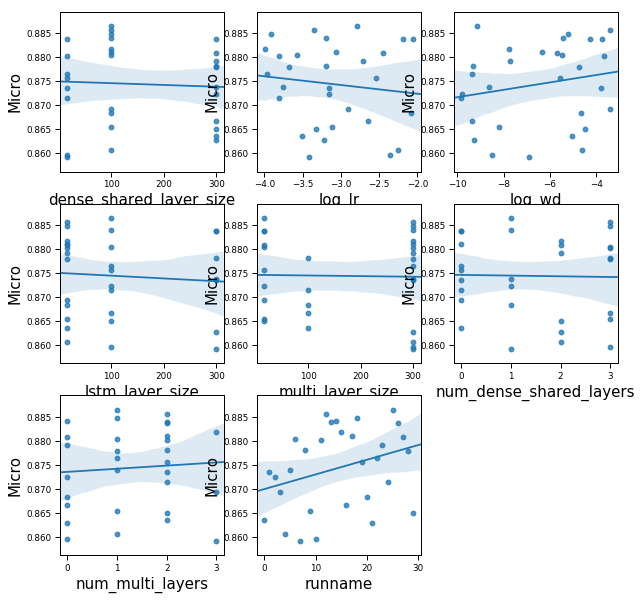

In [510]:
def plot_hp_dependence(val_dfs, settings_df, exp_name):
    plt.figure(figsize=(10,10))
    for i, c in enumerate(settings_df.columns):
        plt.subplot(3, 3, i+1)
        sns.regplot(x=settings_df[c], y=val_dfs[exp_name]['Micro'], fit_reg=True)
    # plt.tight_layout()
    plt.show()

exp_names = ['moe_exp', 'global_exp', 'MTL_careunit_exp']
for exp_name in exp_names:
    print(exp_name)
    plot_hp_dependence(val_dfs, settings_df, exp_name)

### partial dependence plot for cluster and models

In [629]:
# get validation performance
exp_names = ['global_plus_mtl_exp', 'ae_plus_mtl_exp', 
             'val_curve_plus_mtl_exp', 'global_plus_snapshot_exp', 
             'val_curve_plus_snapshot_exp'
            ]
runnames = list(range(30))

pds = {}
for exp_name in exp_names:
    pd_dict = {}
    for run in runnames:
        try: # todo: investigate
            pd_dict[run] =np.load('multitask-patients/mortality_test/results/val_auc_on_{}_single_{}.npy'.format(run, exp_name))[-2:]    
        except:
            print("{} missing run {}".format(exp_name, run))
            continue
            
    df = pd.DataFrame.from_dict(pd_dict)
    df = df.rename({0: 'Macro', 1: 'Micro'}, axis='index')    
    pds[exp_name] = df.transpose()

val_dfs = pds
val_dfs['global_plus_mtl_exp']

ae_plus_mtl_exp missing run 9
val_curve_plus_mtl_exp missing run 9
val_curve_plus_mtl_exp missing run 16
val_curve_plus_mtl_exp missing run 19
val_curve_plus_mtl_exp missing run 20
val_curve_plus_mtl_exp missing run 25
val_curve_plus_mtl_exp missing run 27
global_plus_snapshot_exp missing run 23
val_curve_plus_snapshot_exp missing run 9
val_curve_plus_snapshot_exp missing run 16
val_curve_plus_snapshot_exp missing run 19
val_curve_plus_snapshot_exp missing run 20
val_curve_plus_snapshot_exp missing run 25
val_curve_plus_snapshot_exp missing run 27


,Macro,Micro
0,0.801935,0.862131
1,0.829900,0.871230
2,0.762813,0.855240
3,0.783907,0.858822
4,0.793602,0.868690
5,0.811452,0.881280
6,0.537549,0.870209
7,0.593109,0.873427
8,0.798640,0.869278
9,0.624762,0.870758


In [630]:
# plot partial dependence of all the hyper-parameters, based on validation performance
from collections import defaultdict
cluster_settings, model_settings = joblib.load('multitask-patients/settings/cluster_model_settings.pkl')
pd_dict = defaultdict(lambda: np.zeros(len(settings)))
for i, setting in enumerate(zip(cluster_settings, model_settings)):
    cluster_setting, model_setting = setting

    for arg in cluster_setting:
        if type(arg) in [list, tuple]:
            k, v = arg
        else:
            k, v = arg, 1
        if k.startswith('--'):
            k = k[2:]
        elif k.startswith('-'):
            k = k[1:]
        
        if k == 'lr':
            k = 'log_lr'
            v = np.log10(v)
        if k == 'wd':
            k = 'log_wd'
            v = np.log10(v)
        if type(v) is str: continue
        pd_dict['cluster_' + str(k)][i] = v
    
    for arg in model_setting:
        if type(arg) in [list, tuple]:
            k, v = arg
        else:
            k, v = arg, 1
        if k.startswith('--'):
            k = k[2:]
        elif k.startswith('-'):
            k = k[1:]
        
        if k == 'lr':
            k = 'log_lr'
            v = np.log10(v)
        if k == 'wd':
            k = 'log_wd'
            v = np.log10(v)
        if type(v) is str: continue
        pd_dict['model_' + str(k)][i] = v
        
settings_df = pd.DataFrame.from_dict(pd_dict)
settings_df

,cluster_latent_dim,cluster_log_lr,cluster_log_wd,cluster_not_pt,cluster_num_clusters,cluster_pmt,model_dense_shared_layer_size,model_log_lr,model_log_wd,model_lstm_layer_size,model_multi_layer_size,model_num_dense_shared_layers,model_num_multi_layers,model_pmt,model_sample_weights
0,16.0,-3.454735,-6.493182,0.0,4.0,1.0,300.0,-3.509574,-5.045501,16.0,100.0,0.0,2.0,1.0,0.0
1,16.0,-3.903045,-8.679625,0.0,3.0,1.0,16.0,-3.156900,-3.808226,300.0,300.0,0.0,2.0,1.0,0.0
2,300.0,-2.990678,-4.901031,1.0,4.0,1.0,300.0,-3.160954,-9.793811,100.0,16.0,1.0,0.0,0.0,1.0
3,16.0,-3.901813,-9.717833,1.0,2.0,1.0,100.0,-2.906628,-3.395235,16.0,16.0,0.0,3.0,1.0,1.0
4,100.0,-2.495090,-7.048361,0.0,2.0,1.0,100.0,-2.251728,-4.612949,16.0,300.0,2.0,1.0,1.0,0.0
5,16.0,-2.093584,-8.755725,1.0,2.0,1.0,300.0,-3.751864,-8.642422,300.0,300.0,1.0,1.0,0.0,0.0
6,500.0,-2.215324,-8.034080,0.0,3.0,0.0,100.0,-3.571659,-5.478277,100.0,16.0,3.0,1.0,0.0,1.0
7,100.0,-3.593453,-4.784170,0.0,4.0,0.0,16.0,-3.417487,-6.914898,300.0,300.0,1.0,3.0,1.0,1.0
8,500.0,-2.613914,-5.903783,0.0,2.0,1.0,300.0,-3.192941,-9.316436,300.0,100.0,3.0,2.0,1.0,0.0
9,100.0,-3.151118,-4.403116,1.0,5.0,0.0,100.0,-3.121942,-8.211030,16.0,16.0,3.0,1.0,0.0,1.0


In [632]:
settings_df.loc[[9, 16, 19, 20, 25, 27]]

,cluster_latent_dim,cluster_log_lr,cluster_log_wd,cluster_not_pt,cluster_num_clusters,cluster_pmt,model_dense_shared_layer_size,model_log_lr,model_log_wd,model_lstm_layer_size,model_multi_layer_size,model_num_dense_shared_layers,model_num_multi_layers,model_pmt,model_sample_weights
9,100.0,-3.151118,-4.403116,1.0,5.0,0.0,100.0,-3.121942,-8.211030,16.0,16.0,3.0,1.0,0.0,1.0
16,500.0,-2.791957,-7.020909,1.0,2.0,1.0,300.0,-2.651224,-9.383258,100.0,100.0,3.0,0.0,1.0,1.0
19,500.0,-3.457557,-5.911390,1.0,2.0,0.0,16.0,-2.539923,-5.548824,100.0,16.0,0.0,2.0,0.0,1.0
20,500.0,-3.892798,-9.046304,1.0,2.0,1.0,100.0,-2.084979,-4.673504,16.0,100.0,1.0,0.0,0.0,0.0
25,100.0,-3.894924,-3.089710,0.0,5.0,1.0,100.0,-2.787634,-9.165050,100.0,16.0,1.0,1.0,0.0,0.0
27,500.0,-2.239408,-4.167921,0.0,5.0,1.0,300.0,-2.456922,-5.694917,16.0,16.0,2.0,0.0,1.0,1.0


global_plus_mtl_exp


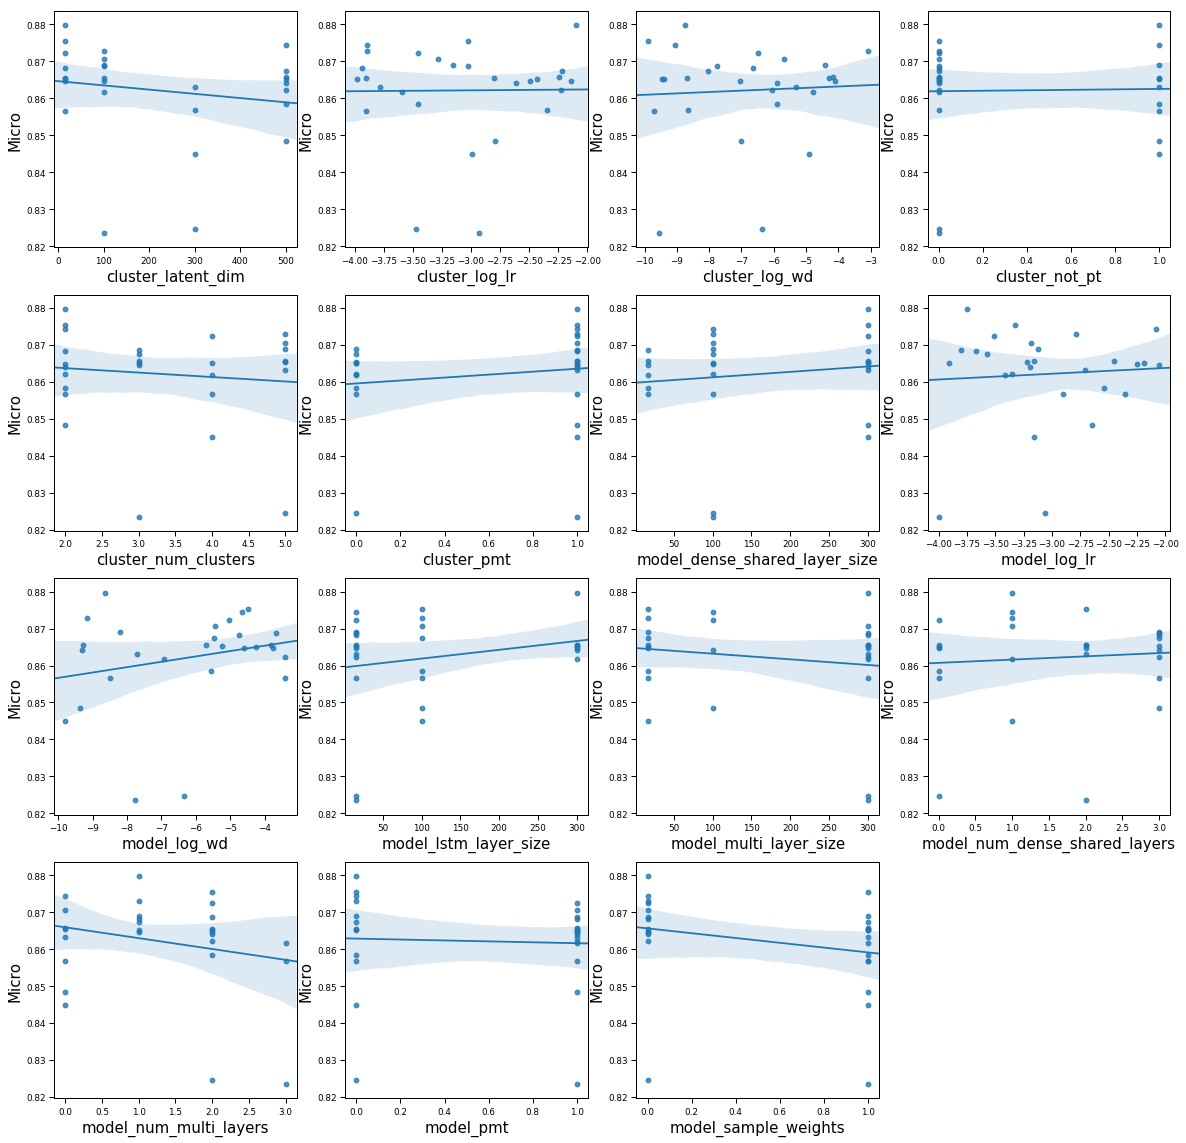

ae_plus_mtl_exp


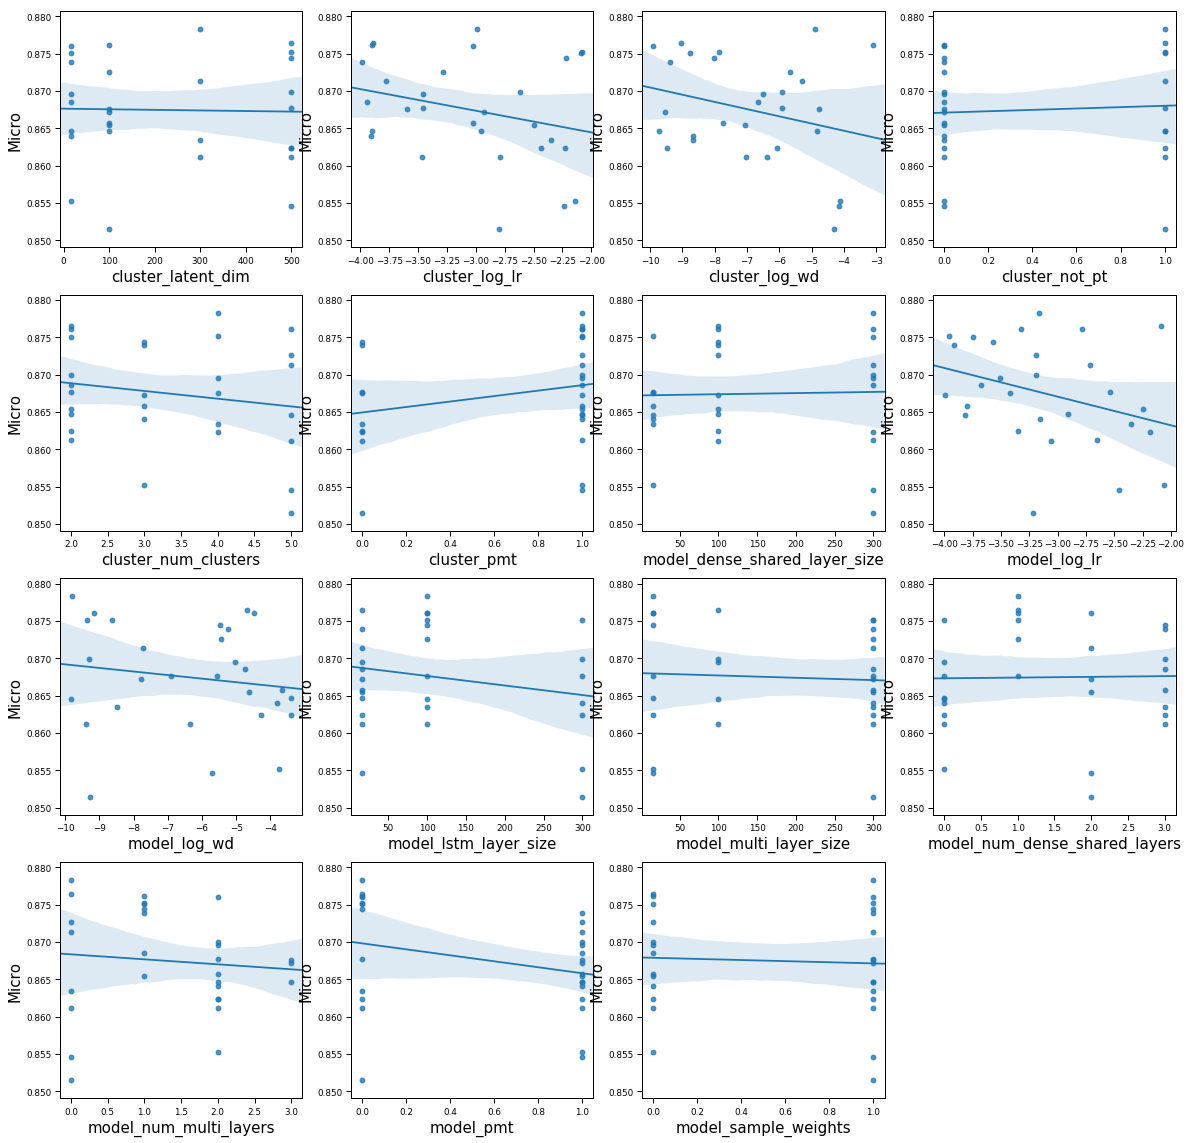

val_curve_plus_mtl_exp


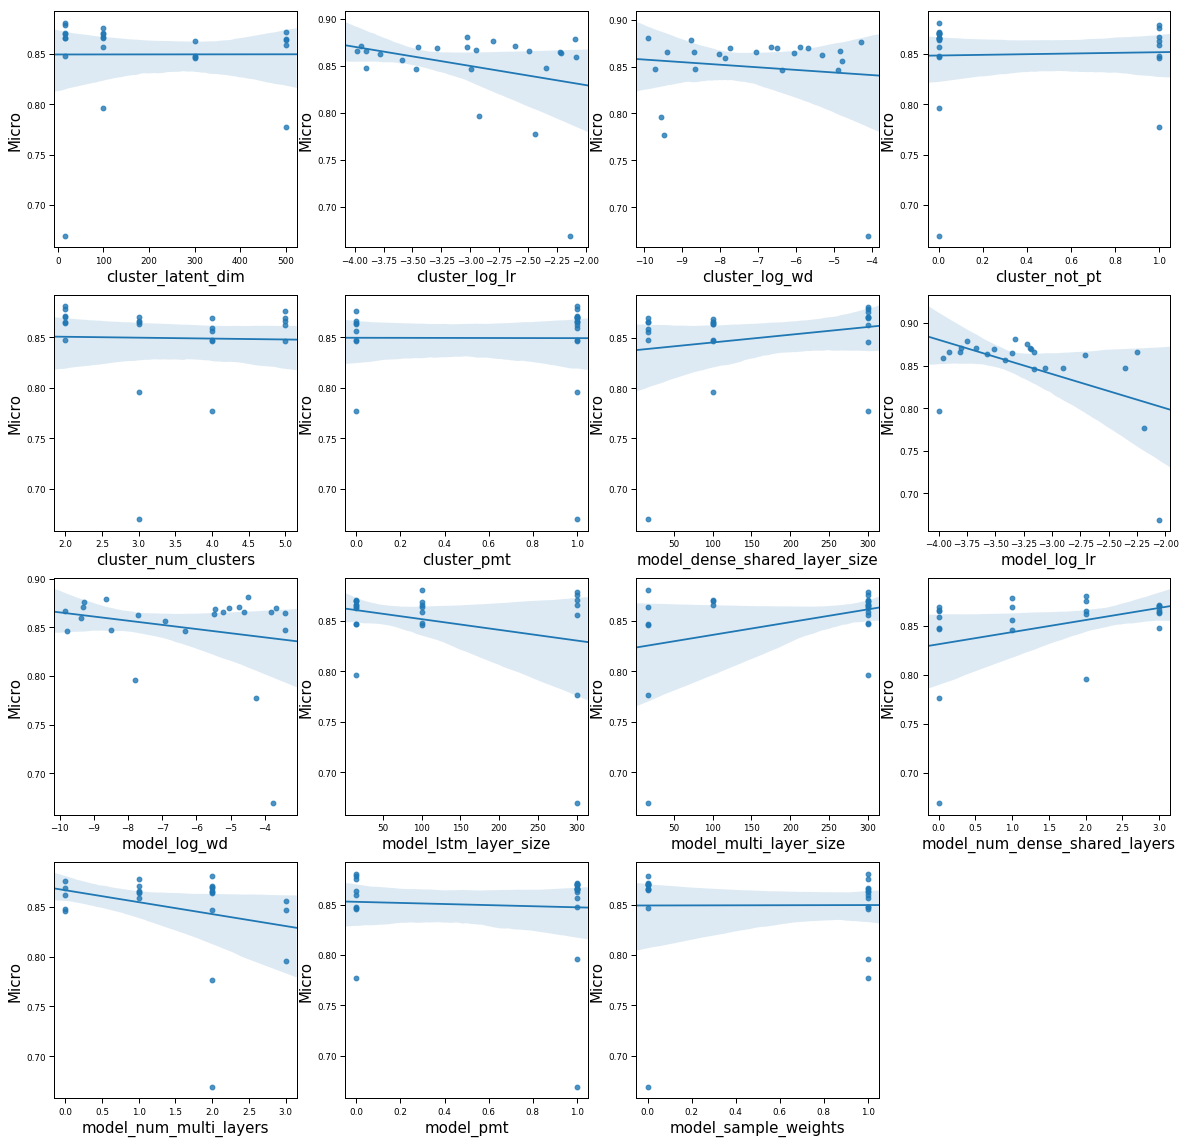

global_plus_snapshot_exp


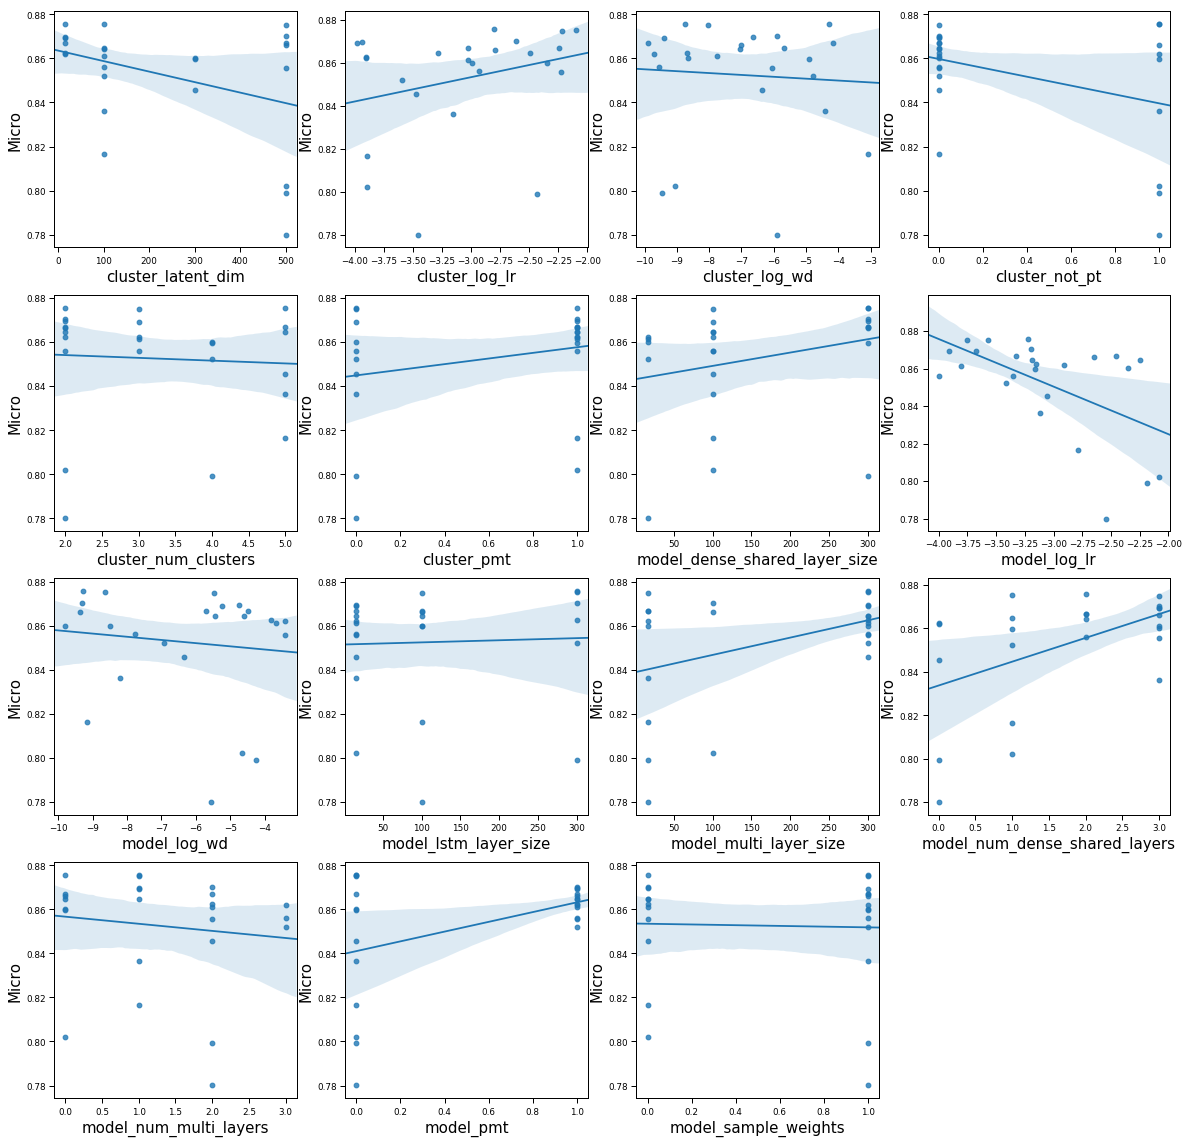

val_curve_plus_snapshot_exp


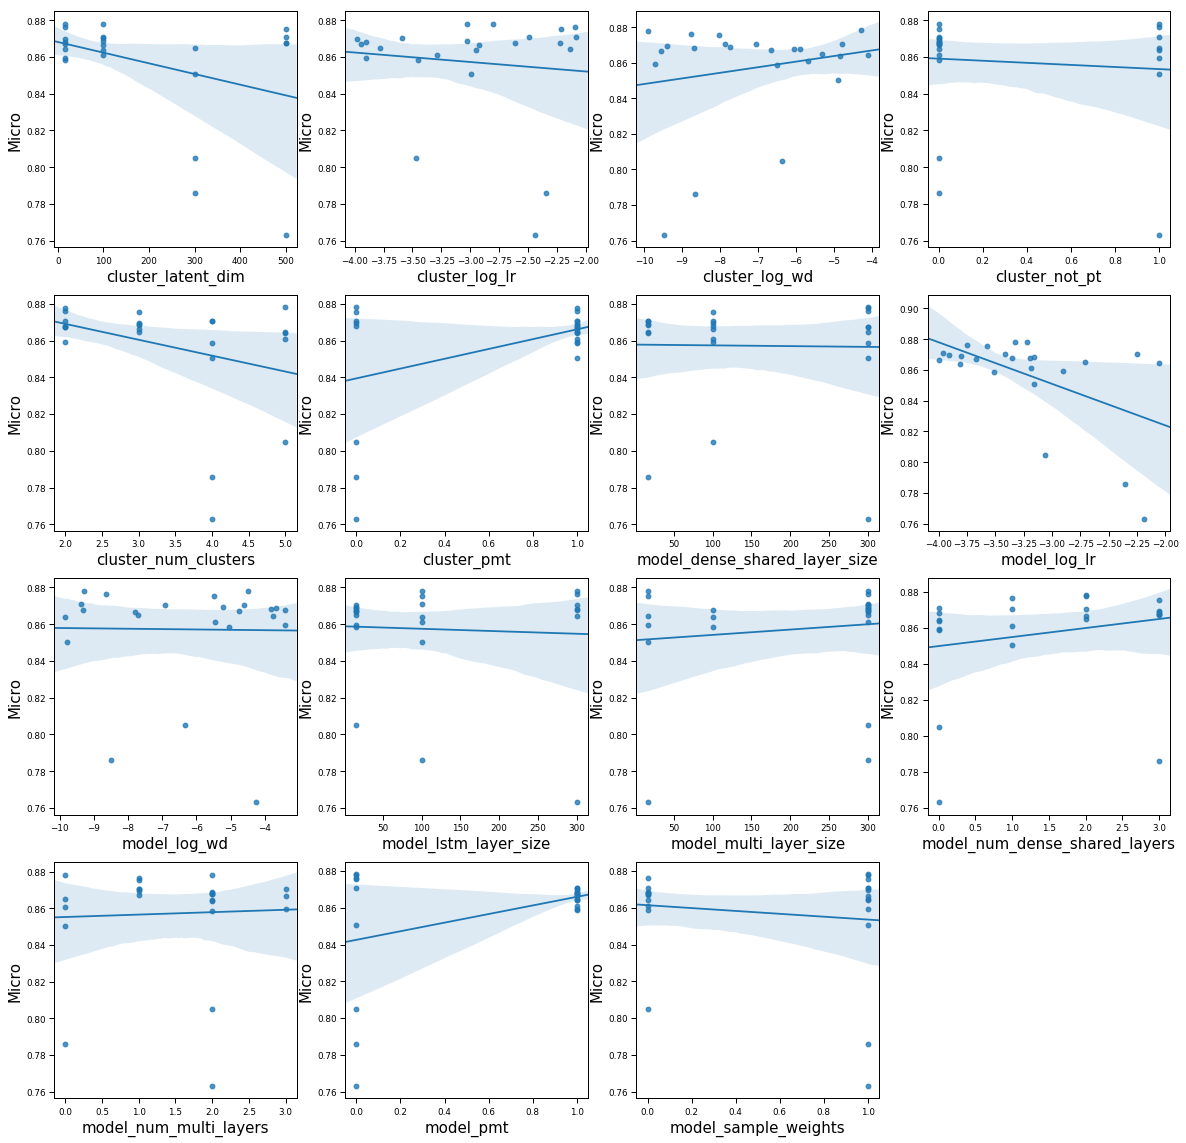

In [628]:
def plot_hp_dependence(val_dfs, settings_df, exp_name):
    plt.figure(figsize=(20,20))
    for i, c in enumerate(settings_df.columns):
        plt.subplot(4, 4, i+1)
        idx = val_dfs[exp_name]['Micro'].index
        sns.regplot(x=settings_df[c][idx], y=val_dfs[exp_name]['Micro'], fit_reg=True)
        
    # plt.tight_layout()
    plt.show()

exp_names = ['global_plus_mtl_exp', 'ae_plus_mtl_exp', 
             'val_curve_plus_mtl_exp', 'global_plus_snapshot_exp', 
             'val_curve_plus_snapshot_exp'
            ]
for exp_name in exp_names:
    print(exp_name)
    plot_hp_dependence(val_dfs, settings_df, exp_name)

# data check

In [684]:
save_data_path = "mixture_of_experts_project/data/mortality_24/"
X = np.load(save_data_path + 'X.npy')
# jw: need to allow_pickle=True                                                                                                                                                                                 
careunits = np.load(save_data_path + 'careunits.npy', allow_pickle=True)
saps_quartile = np.load(save_data_path + 'saps_quartile.npy')
subject_ids = np.load(save_data_path + 'subject_ids.npy')
Y = np.load(save_data_path + 'Y.npy')

pd_dict = {}
all_tasks = sorted(np.unique(careunits))
for task in all_tasks:
    subset = (careunits == task)
    n_samples = sum(subset)
    n_pos_samples = sum(Y[subset])
    pd_dict[task] = {'N': n_samples, 'n': n_pos_samples, 'Class Imbalance': float(n_pos_samples) / n_samples}

df = pd.DataFrame.from_dict(pd_dict).T
df2 = pd.DataFrame.from_dict({'Overall': {'N': len(Y), 'n': sum(Y), 'Class Imbalance': float(sum(Y)) / len(Y)}}).T
df = df.append(df2)

In [687]:
df.round(3)[['N', 'n', 'Class Imbalance']]

,N,n,Class Imbalance
CCU,4888.0,340.0,0.070
CSRU,6977.0,136.0,0.019
MICU,11429.0,1120.0,0.098
SICU,5183.0,398.0,0.077
TSICU,4234.0,284.0,0.067
Overall,32711.0,2278.0,0.070
